In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import os
import re
from scipy.signal import argrelextrema
import pandas as pd

In [2]:
from box_coordinates_and_paths import choose_region

In [3]:
def savefig(filename, directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        plt.savefig(directory_path + filename, facecolor='white', bbox_inches='tight')
    else:
        plt.savefig(directory_path + filename, facecolor='white', bbox_inches='tight')
        
def save_netcdf(ds, name_file, directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        ds.to_netcdf(directory_path + name_file, mode='w')
    else:
        ds.to_netcdf(directory_path + name_file, mode='w')

In [4]:
def increment_number_in_string(input_string):
    # Use regular expression to find the number in the string
    pattern = r'\d+'
    match = re.search(pattern, input_string)

    if match:
        # Extract the matched number
        number_str = match.group(0)
        # Convert it to an integer, increment by 1, and convert it back to a string
        incremented_number = str(int(number_str) + 1)

        # Replace the matched number with the incremented number in the original string
        result_string = re.sub(pattern, incremented_number, input_string, count=1)
        return result_string
    else:
        # If no number was found in the string, return the original string
        return input_string

In [26]:
def combined_get_top_ABL(ax, data, vertical_boundary, skip_noisy_bottom_levels, levels_for_fit, cell_height_in_meter, ocean_type):
    print("This is combined_get_top_ABL.py speaking: I START WORKING NOW! \n")
    
    x_full = data.mean(dim='cell')[:vertical_boundary]
    y_full = cell_height_in_meter.isel(height=slice(0, len(x_full)))[:vertical_boundary]

    line1, = ax.plot(x_full, y_full, marker='o', linestyle='-', color='black', ms=7, lw=3, clip_on=False, label=r'$\tau$')
    ax.axvline(0, color='grey', lw=1, ls='dashed', zorder=-1)
    ax.axhline(1000, color='grey', lw=1, ls='dashed', zorder=-1)
    ax.axhline(2000, color='grey', lw=1, ls='dashed', zorder=-1)
    ax.axhline(3000, color='grey', lw=1, ls='dashed', zorder=-1)
    ax.axhline(4000, color='grey', lw=1, ls='dashed', zorder=-1)

    ax.set_ylim(bottom=0, top=y_full[-1])
    ax.set_ylabel('Altitude / m')
    ax.set_xlabel(r'Vertical Turbulent Flux / $\mathrm{ms}^{-2}$')
    ax.spines[['left', 'bottom']].set_position(('outward',20))

    # Intro Method-1
    diff_between_integrals = np.abs(np.diff(x_full))
    #ax.plot(diff_between_integrals[:skip_noisy_bottom_levels], y_full[1:skip_noisy_bottom_levels], color='black', lw=3, ls='dotted', clip_on=False)
    line2, = ax.plot(diff_between_integrals[skip_noisy_bottom_levels:], y_full[1+skip_noisy_bottom_levels:], 
                     marker='o', linestyle='-', color='grey', ms=7, lw=3, clip_on=False, label=r'$\partial_z \tau$')

    # Intro Method-2
    x_fit = x_full.isel(height=slice(skip_noisy_bottom_levels, skip_noisy_bottom_levels+levels_for_fit))
    y_fit = y_full.isel(height=slice(skip_noisy_bottom_levels, skip_noisy_bottom_levels+levels_for_fit))
    
    ## Step 1: Perform the linear fit
    A = np.vstack([y_fit, np.ones(len(x_fit))]).T
    slope, intercept = np.linalg.lstsq(A, x_fit, rcond=None)[0]
    
    ## Step 2: Compute the fitted line and boundaries
    fit = slope * y_full.isel(height=slice(skip_noisy_bottom_levels, None)) + intercept
    tolerance = 0.1 * np.abs(slope * y_full.isel(height=slice(skip_noisy_bottom_levels, None)))
    fit_upper_boundary = fit + tolerance
    fit_lower_boundary = fit - tolerance

    try:
        # Attempt to run METHOD-1:
        ### for local minima
        top_of_ABL = argrelextrema(diff_between_integrals[skip_noisy_bottom_levels:], np.less)[0][0]
        top_of_ABL += skip_noisy_bottom_levels+1 
        line3, = ax.plot(diff_between_integrals[top_of_ABL], y_full.isel(height=top_of_ABL), 
                         marker='o', linestyle='None', markerfacecolor='none', markeredgecolor='cornflowerblue', ms=20, markeredgewidth=3, 
                         clip_on=False, label=r'$\mathrm{min}(\partial_z \tau)$')

        line4, = ax.plot(20, 20, color='cornflowerblue', lw=3, label='Linear Fit')
        ax.plot(20, 20, color='green', lw=3)
        line5, = ax.plot(20, 20, color='orange', lw=3, label='20% Window')
        
        # 16; i.e. higher than 3000m
        # 15; i.e. higher than 2530m according to Nuijens et al. 2022. Top of inversion layer. 
        # 14; i.e. higher than 2256m
        # 13; i.e. higher than 1995m
        ABL_threshold = 15
        if top_of_ABL >= ABL_threshold:
            raise ValueError(f"top_of_ABL index is {top_of_ABL}, which is >= {ABL_threshold} and >= {cell_height_in_meter[ABL_threshold].values}. Skipping to the next method.")
        
        #print('Top of ABL is at: ', cell_height_in_meter[skip_noisy_bottom_levels+top_of_ABL].values, 'meter and at level', skip_noisy_bottom_levels+top_of_ABL)
        
        line6, = ax.plot(x_full.isel(height=top_of_ABL), y_full.isel(height=top_of_ABL), 
                         marker='o', linestyle='None', markerfacecolor='none', markeredgecolor='red', ms=20, markeredgewidth=3, 
                         clip_on=False, label=r'$H_0$ by Method-1')
        line7, = ax.plot(20, 20, marker='x', color='red', ls='None', ms=20, markeredgewidth=3, label=r'$H_0$ by Method-2') #dummy 
        line8, = ax.plot(20, 20, marker='x', color='white', ls='None', ms=20, markeredgewidth=3, label=r'Dummy Label') #dummy 
        
    except Exception as e:
        # If an error occurs, fall back to METHOD-2 logic
        print(f"An error occurred in METHOD-1 logic: {e}")
        ## Step 3: Identify the first point outside the +/-10% boundary

        ax.plot(x_fit, y_fit, marker='o', linestyle='-', color='cornflowerblue', ms=7, lw=3, markeredgewidth=3, clip_on=False)
        
        line4, = ax.plot(fit, y_full.isel(height=slice(skip_noisy_bottom_levels, None)), color='cornflowerblue', lw=3, label='Linear Fit')
        ax.plot(fit_upper_boundary, y_full.isel(height=slice(skip_noisy_bottom_levels, None)), color='orange', lw=3)
        line5, = ax.plot(fit_lower_boundary, y_full.isel(height=slice(skip_noisy_bottom_levels, None)), color='orange', lw=3, label='20% Window')
        
        check_within_range = np.abs(x_full.isel(height=slice(skip_noisy_bottom_levels, None)) - fit) <= tolerance
        where_out_of_range = (~check_within_range[levels_for_fit:]).argmax(dim='height').values

        line6, = ax.plot(x_full.isel(height=slice(skip_noisy_bottom_levels+levels_for_fit, None)).isel(height=where_out_of_range), y_full.isel(height=slice(skip_noisy_bottom_levels+levels_for_fit, None)).isel(height=where_out_of_range), 
                         marker='o', markerfacecolor='none', color='red', ls='None', ms=20, markeredgewidth=3, clip_on=False, label=r'$H_0$ by Method-2')
        top_of_ABL = skip_noisy_bottom_levels+levels_for_fit+where_out_of_range

    #plt.ylim(0,1000)
    #plt.xlim(-0.1,0.1)
    #handles, labels = plt.gca().get_legend_handles_labels()
    #print(handles)
    #print(labels)
    #order = [4,3,2,0,1]  # Specify the new order (reordering the items in the legend)
    #ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=7)
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=7)
    #text = r'$H_0$'+f' is at {cell_height_in_meter[top_of_ABL].values:.0f}m, model level = {top_of_ABL}'
    #ax.annotate(text, xy=(0.5, 0), xycoords='axes fraction', 
    #            textcoords='offset points', ha='center', va='center',
    #            bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white'),
    #            fontsize=15)
    
    ax.spines[['left', 'bottom']].set_position(('outward',20))
    ax.spines[['left', 'bottom']].set_visible(True)
    ax.spines[['right', 'top']].set_visible(False)

    filename = f'{year}_{season}_{ocean_type}_top_of_ABL.png'

    #print('H_0 is at level = ', top_of_ABL, 'at', cell_height_in_meter[top_of_ABL].values)
    return top_of_ABL, filename, ocean_type#, handles, labels

In [6]:
def get_mask(ocean_type, dpp, year, season):
    degrees_lower_box_bound, degrees_upper_box_bound, degrees_left_box_bound, degrees_right_box_bound = choose_region(ocean_type)
    new_grid  = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/new_grids/new_grid_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc")
    filepath  = f"/work/mh0731/m300868/00_DATA/{dpp}/09_wrapped_up_datasets/{year}/09_{dpp}_WRAPUP_dataset_region_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}_year_{year}_season_{season}.nc"                    
    data      = xr.open_dataset(filepath)
    data      = xr.merge([xr.where(data['valid']==1, True, False), xr.where(data['valid_oce']==1, True, False), xr.where(data['mask']==1, True, False), xr.where(data['mask_oce']==1, True, False), data.drop({'valid', 'valid_oce', 'mask', 'mask_oce'})])
    valid     = data.valid.values
    mask      = data.mask.values
    two_to_two_mask = np.where((new_grid.sel(cell=valid).sel(cell=mask).clat < np.deg2rad(2)) & 
                               (new_grid.sel(cell=valid).sel(cell=mask).clat > np.deg2rad(-2)), True, False)
    return two_to_two_mask, valid, mask, data

In [7]:
# ['atlantic', 'western_pacific', 'central_pacific', 'eastern_pacific', 'indian_ocean']
# ['MAM', 'JJA', 'SON', 'DJF']
# ['2020', '2021', '2022']

In [8]:
dpp = 'ngc2009'
vertical_boundary = 21
skip_noisy_bottom_levels = 3
levels_for_fit = 6

## Top of ABL

In [9]:
datapath_ABL = "/work/mh0731/m300868/00_DATA/Paper_Data_Revised/"

seasons_df = pd.read_csv(datapath_ABL+'top_of_ABL_combined_review.csv', index_col=0)
seasons_df

,2020-MAM,2020-JJA,2020-SON,2021-DJF,2021-MAM,2021-JJA,2021-SON,2022-DJF
western_pacific,8,8,8,7,8,8,8,7
central_pacific,8,8,8,8,8,8,8,8
eastern_pacific,11,11,13,11,11,12,12,11
indian_ocean,7,7,8,9,8,8,7,12
atlantic,9,10,13,11,9,7,14,9


In [10]:
ocean_type = 'eastern_pacific'
season = 'MAM'
year = '2021'

filename = f'{year}_{season}_{ocean_type}_vert_fluxes.nc'
filepath = f"/work/mh0731/m300868/00_DATA/Paper_Data/vert_turb_flux/{ocean_type}/"
epcf_turb_data = xr.open_dataset(filepath+filename)

In [11]:
epcf_two_to_two_mask, epcf_valid, epcf_mask, epcf_data = get_mask(ocean_type, dpp, year, season)

/tmp/ipykernel_2101944/784763370.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  data      = xr.merge([xr.where(data['valid']==1, True, False), xr.where(data['valid_oce']==1, True, False), xr.where(data['mask']==1, True, False), xr.where(data['mask_oce']==1, True, False), data.drop({'valid', 'valid_oce', 'mask', 'mask_oce'})])


In [12]:
epcf_total_turb_stress_mom = -epcf_turb_data.total_turb_stress_mom.sel(cell=epcf_two_to_two_mask)
epcf_cell_height_in_meter = epcf_turb_data.mean_cell_height
epcf_top_of_ABL = seasons_df.loc[f'{ocean_type}'][f'{year}-{season}']

In [13]:
ua_epcf = epcf_data.uu.sel(all_cells=epcf_valid).sel(all_cells=epcf_mask).sel(all_cells=epcf_two_to_two_mask)
va_epcf = epcf_data.vv.sel(all_cells=epcf_valid).sel(all_cells=epcf_mask).sel(all_cells=epcf_two_to_two_mask)

In [14]:
ocean_type = 'atlantic'
season = 'SON'
year = '2020'

filename = f'{year}_{season}_{ocean_type}_vert_fluxes.nc'
filepath = f"/work/mh0731/m300868/00_DATA/Paper_Data/vert_turb_flux/{ocean_type}/"
atl_turb_data = xr.open_dataset(filepath+filename)

In [15]:
atl_two_to_two_mask, atl_valid, atl_mask, atl_data = get_mask(ocean_type, dpp, year, season)

/tmp/ipykernel_2101944/784763370.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  data      = xr.merge([xr.where(data['valid']==1, True, False), xr.where(data['valid_oce']==1, True, False), xr.where(data['mask']==1, True, False), xr.where(data['mask_oce']==1, True, False), data.drop({'valid', 'valid_oce', 'mask', 'mask_oce'})])


In [16]:
atl_total_turb_stress_mom = -atl_turb_data.total_turb_stress_mom.sel(cell=atl_two_to_two_mask)
atl_cell_height_in_meter = atl_turb_data.mean_cell_height
atl_top_of_ABL = seasons_df.loc[f'{ocean_type}'][f'{year}-{season}']

In [17]:
ua_atl = atl_data.uu.sel(all_cells=atl_valid).sel(all_cells=atl_mask).sel(all_cells=atl_two_to_two_mask)
va_atl = atl_data.vv.sel(all_cells=atl_valid).sel(all_cells=atl_mask).sel(all_cells=atl_two_to_two_mask)

In [18]:
mean_cell_height = (atl_turb_data.mean_cell_height + epcf_turb_data.mean_cell_height) / 2

In [19]:
SIZE = 25
plt.rcParams["axes.labelsize"] = SIZE
plt.rcParams["legend.fontsize"] = SIZE
plt.rcParams["xtick.labelsize"] = SIZE
plt.rcParams["ytick.labelsize"] = SIZE
plt.rcParams["font.size"] = SIZE
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['ytick.major.size'] = 12

This is combined_get_top_ABL.py speaking: I START WORKING NOW! 

An error occurred in METHOD-1 logic: index 0 is out of bounds for axis 0 with size 0
Top ABL for eastern_pacific is at 1516.416748046875.
This is combined_get_top_ABL.py speaking: I START WORKING NOW! 

Top ABL for atlantic is at 1994.526123046875.


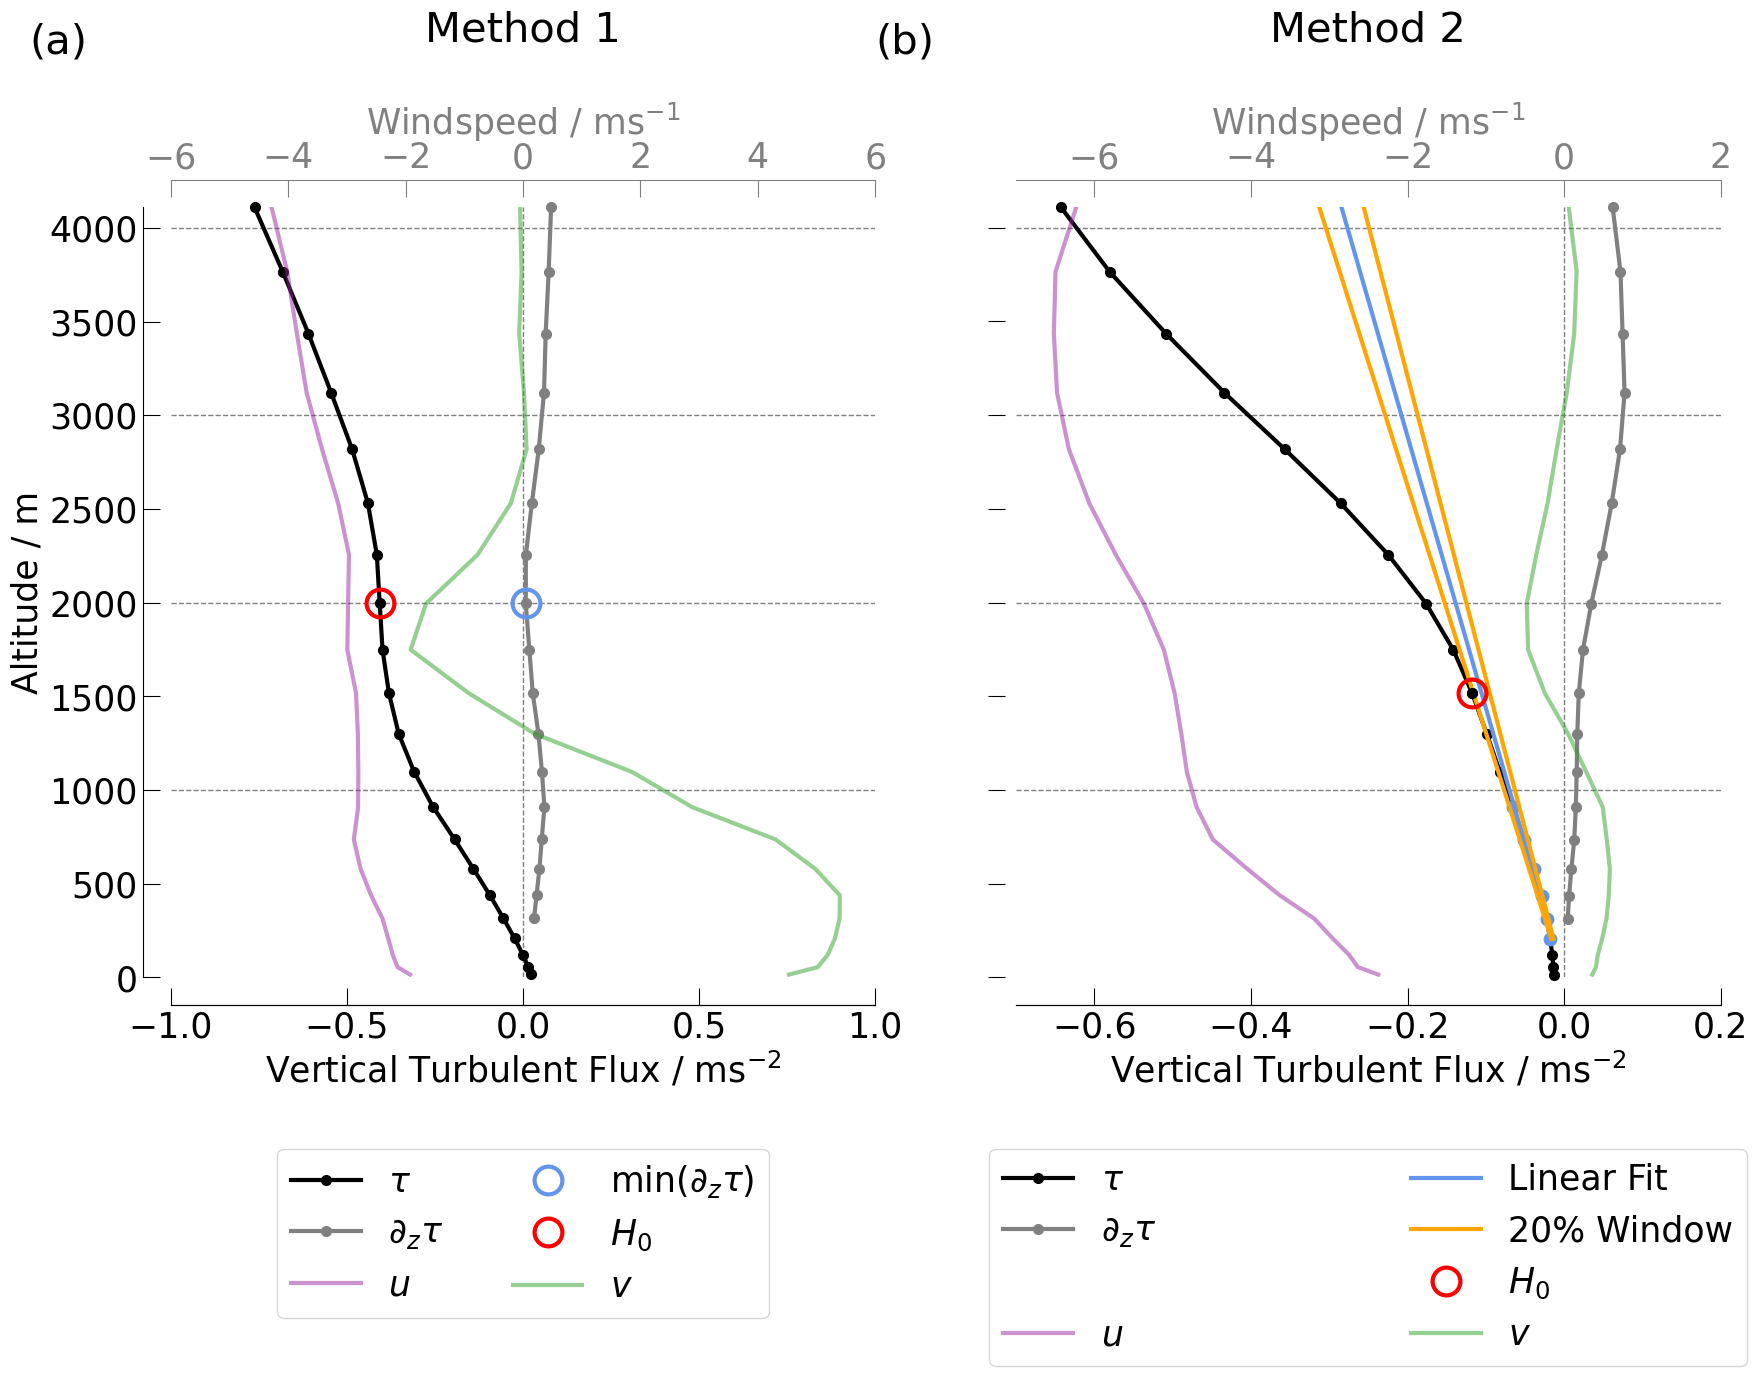

In [27]:
# Start Plotting
fig = plt.figure(figsize=(20,10), facecolor='w', edgecolor='k')
#fig.suptitle(f'{ocean_type}: {year} {season}', fontsize=15, y=.93)
G = gridspec.GridSpec(1,2)

ax1 = plt.subplot(G[0,1])
ax11 = ax1.twiny()

ocean_type = "eastern_pacific"
top_of_ABL, filename, ocean_type = combined_get_top_ABL(ax1, epcf_total_turb_stress_mom, vertical_boundary, skip_noisy_bottom_levels, levels_for_fit, epcf_cell_height_in_meter, ocean_type)

print(f"Top ABL for {ocean_type} is at {y_full[top_of_ABL].values}.")

x_full = epcf_total_turb_stress_mom.mean(dim='cell')[:vertical_boundary]
y_full = epcf_cell_height_in_meter.isel(height=slice(0, len(x_full)))[:vertical_boundary]
ax1.plot(x_full[top_of_ABL], y_full[top_of_ABL], marker='o', linestyle='-', color='black', ms=7, lw=3, clip_on=False, zorder=100)

uref, = ax11.plot(ua_epcf.mean(dim='all_cells'), mean_cell_height[:21],
         color='#9726A0', linestyle='solid', lw=3, zorder=-1, alpha=0.5)
line11, = ax11.plot(va_epcf.mean(dim='all_cells'), mean_cell_height[:21],
         color='#2FA026', linestyle='solid', lw=3, zorder=-1, alpha=0.5, label=r'$v$')

#ax.get_legend().remove()
ax1.set_xlim(-0.7,0.2)
ax1.text(-0.2, 1.2, '(b)', fontsize=SIZE+5, transform=ax1.transAxes)
ax1.set_title(r'Method 2', pad=120)

ax1.spines[['left']].set_visible(False)
ax1.spines['left'].set_color('white') 
ax1.tick_params(axis='y', labelcolor='white', color='black')
ax1.yaxis.label.set_color('white') 

ax11.set_xlim(-7,2)
ax11.set_xlabel(r'Windspeed / $\mathrm{ms}^{-1}$', color='grey')
ax11.tick_params(axis='x', colors='grey')
ax11.spines['top'].set_color('grey')

ax11.spines[['left', 'bottom', 'top']].set_position(('outward',20))
ax11.spines[['bottom']].set_visible(True)
ax11.spines[['right', 'left']].set_visible(False)

#####################################################################################################################
#####################################################################################################################

ax2 = plt.subplot(G[0,0])
ax22 = ax2.twiny()

ocean_type = "atlantic"
top_of_ABL, filename, ocean_type = combined_get_top_ABL(ax2, atl_total_turb_stress_mom, vertical_boundary, skip_noisy_bottom_levels, levels_for_fit, atl_cell_height_in_meter, ocean_type)

print(f"Top ABL for {ocean_type} is at {y_full[top_of_ABL].values}.")

line9, = ax22.plot(ua_atl.mean(dim='all_cells'), mean_cell_height[:21],
         color='#9726A0', linestyle='solid', lw=3, zorder=-1, alpha=0.5, label=r'$u$')
line10, = ax22.plot(va_atl.mean(dim='all_cells'), mean_cell_height[:21],
         color='#2FA026', linestyle='solid', lw=3, zorder=-1, alpha=0.5, label=r'$v$')

#ax.get_legend().remove()
ax2.set_xlim(-1,1)
ax2.text(-0.2, 1.2, '(a)', fontsize=SIZE+5, transform=ax2.transAxes)
ax2.set_title(r'Method 1', pad=120)

ax22.set_xlim(-6,6)
ax22.set_xlabel(r'Windspeed / $\mathrm{ms}^{-1}$', color='grey')
ax22.tick_params(axis='x', colors='grey')
ax22.spines['top'].set_color('grey')

ax22.spines[['left', 'bottom', 'top']].set_position(('outward',20))
ax22.spines[['bottom']].set_visible(True)
ax22.spines[['right', 'left']].set_visible(False)

#####################################################################################################################
# Legend stuff
#####################################################################################################################

line1, = ax2.plot(20, 20,
                  marker='o', linestyle='-', color='black', ms=7, lw=3, label=r'$\tau$')
line2, = ax2.plot(20, 20, 
                  marker='o', linestyle='-', color='grey', ms=7, lw=3, label=r'$\partial_z \tau$')
line3, = ax2.plot(20, 20, 
                  marker='o', linestyle='None', markerfacecolor='none', markeredgecolor='cornflowerblue', ms=20, markeredgewidth=3, 
                  label=r'$\mathrm{min}(\partial_z \tau)$')
line4, = ax2.plot(20, 20, 
                  color='cornflowerblue', lw=3, label='Linear Fit')
line5, = ax2.plot(20, 20, 
                  color='orange', lw=3, label='20% Window')
line6, = ax2.plot(20, 20, 
                  marker='o', linestyle='None', markerfacecolor='none', markeredgecolor='red', ms=20, markeredgewidth=3, 
                  label=r'$H_0$')
line7, = ax2.plot(20, 20, 
                  marker='o', color='red', ls='None', markerfacecolor='none', ms=20, markeredgewidth=3, label=r'$H_0$') #dummy 
line8, = ax2.plot(20, 20, 
                  marker='o', color='white', ls='None', markerfacecolor='none', ms=20, markeredgewidth=3, label=r'Dummy Label') #dummy 

### Legend1
###########
handles1 = [line1, line2, line8, line9, line4, line5, line7, line11, line10]
labels1 = [line.get_label() for line in handles1]

order1 = [0, 1, 2, 3, 4, 5, 6, 7]  
legend1 = ax11.legend([handles1[idx] for idx in order1], [labels1[idx] for idx in order1], 
                     loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=2)
### Legend2
###########
handles2 = [line1, line2, line3, line6, line9, line10]
labels2 = [line.get_label() for line in handles2]

order2 = [0, 1, 4, 2, 3, 5]  
legend2 = ax2.legend([handles2[idx] for idx in order2], [labels2[idx] for idx in order2], 
                     loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=2)

#####################################################################################################################
# For Dummy Label
#####################################################################################################################

for text, label in zip(legend1.get_texts(), [labels1[idx] for idx in order1]):
    if label == 'Dummy Label':  # Match based on the label in the new order
        text.set_color("white")  # Change the font color to green
        
filename = f'fig_02_appendix_how_to_top_ABL.pdf'
filepath = 'figs_review/'
plt.savefig(filepath + filename, facecolor='white', bbox_inches='tight', dpi=400)
plt.show()